In [1]:
import pandas as pd
import sys

# Introduction

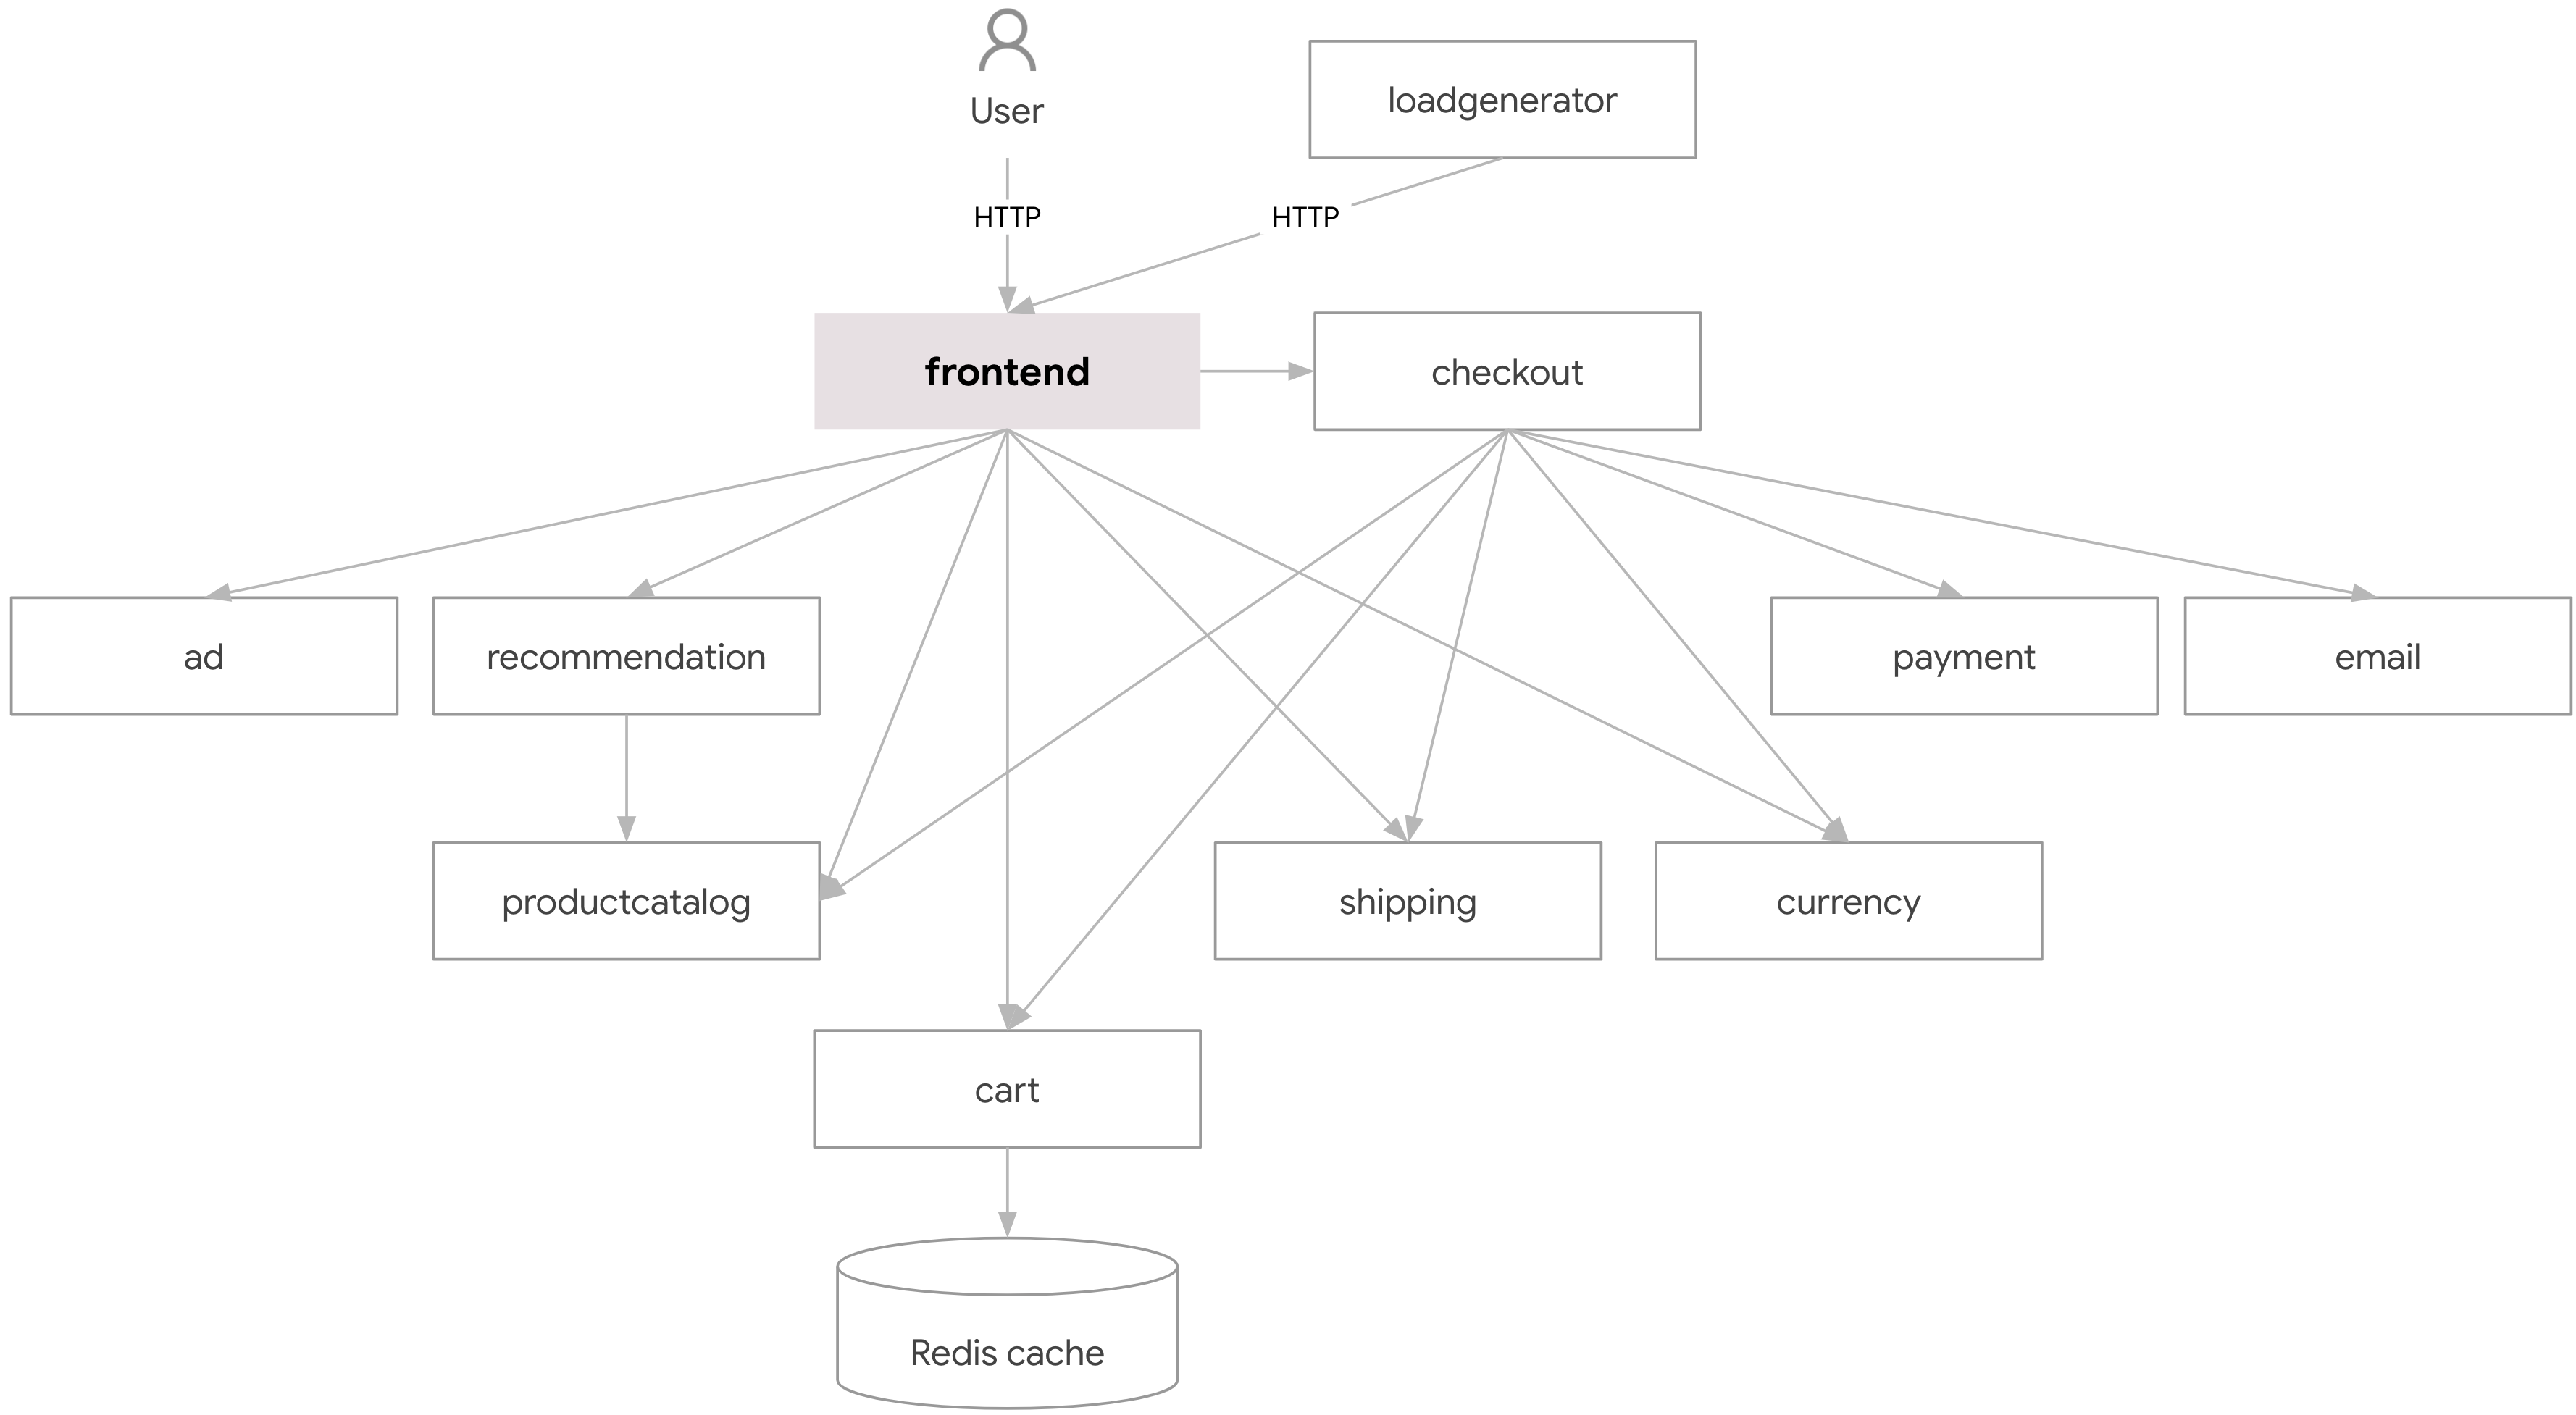

In [2]:
#inline
from IPython.display import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Image('https://raw.githubusercontent.com/GoogleCloudPlatform/microservices-demo/main/docs/img/architecture-diagram.png')

# Data set preprocessing

## Load

In [19]:
# Import multiple latency values
p50 = pd.read_csv("Dataset/p50_latency_gcp.csv")
p95 = pd.read_csv("Dataset/p95_latency_gcp.csv")
p99 = pd.read_csv("Dataset/p99_latency_gcp.csv")
gcp_rps = pd.read_csv("Dataset/gcp_rps.csv")

#Concatenate multiple values
df = pd.concat([p50,p95,p99,gcp_rps], axis=1)

In [20]:
# Assign WEIGHTS
# Configure weights - The idea is to give a very low importance to those services that are not direclty connected
## Multiply *1 - Direct connection
## Multiply *0.3 - 2nd  connection ( Payment , email, redis and product catalog)
weight = 0.3

for col in df.columns:
        if 'redis' in col:
            df[col] = df[col].multiply(weight)
        if 'email' in col:
            df[col] = df[col].multiply(weight)
        if 'payment' in col:
            df[col] = df[col].multiply(weight)

#Send target to the end
s = df.pop('p95 deploy/frontend')
df = pd.concat([df, s], 1)

# Time is multiple times present. I need to keep just 1 sample for time since all of them will have the same value
df=df.loc[:, ~df.columns.duplicated(keep='first')]

#Convert time column to time format
df['Time'] = pd.to_datetime(df['Time'])
df.head()

,Time,p50 deploy/adservice,p50 deploy/cartservice,p50 deploy/checkoutservice,p50 deploy/currencyservice,p50 deploy/emailservice,p50 deploy/frontend,p50 deploy/loadgenerator,p50 deploy/paymentservice,p50 deploy/productcatalogservice,...,deploy/currencyservice,deploy/emailservice,deploy/frontend,deploy/loadgenerator,deploy/paymentservice,deploy/productcatalogservice,deploy/recommendationservice,deploy/redis-cart,deploy/shippingservice,p95 deploy/frontend
0,2021-10-07 09:18:00,3.166667,1.257143,23.333333,0.552147,0.200,43.235294,0.75,0.1875,0.504373,...,0.2,0.06,0.4,0.2,0.06,0.2,0.2,0.06,0.20002,131.000000
1,2021-10-07 09:18:05,2.500000,1.500000,10.000000,0.552147,0.225,43.235294,0.75,0.1875,0.506309,...,0.2,0.06,0.4,0.2,0.06,0.2,0.2,0.06,0.20002,131.000000
2,2021-10-07 09:18:10,2.500000,1.500000,10.000000,0.551136,0.225,41.071429,0.75,0.3000,0.506309,...,0.2,0.06,0.4,0.2,0.06,0.2,0.2,0.06,0.20000,99.027778
3,2021-10-07 09:18:15,2.194444,1.354839,25.000000,0.551136,0.270,41.071429,0.75,0.3000,0.502907,...,0.2,0.06,0.4,0.2,0.06,0.2,0.2,0.06,0.20000,99.027778
4,2021-10-07 09:18:20,2.194444,1.354839,25.000000,0.541985,0.270,41.111111,0.75,0.2625,0.502907,...,0.2,0.06,0.4,0.2,0.06,0.2,0.2,0.06,0.20000,240.000000


## Preporcessing and save DS

In [21]:
df.set_index('Time', inplace=True)
df.sort_index(inplace=True)
# Separate 500 samples for TEST
df_train = df.iloc[:-500,:]
df_test = df.iloc[-500:,:]

df_train=df_train.rename_axis("date")
df_test = df_test.rename_axis("date")

In [22]:
from sklearn.preprocessing import StandardScaler

# Normalize
# Normalization between 0 and 1  THE FEATURES
def normalize(X_train,X_test):
    scaler_X = StandardScaler()
    X_train_normalized = pd.DataFrame(scaler_X.fit_transform(X_train.values), columns=X_train.columns)
    X_test_normalized = pd.DataFrame(scaler_X.transform(X_test.values), columns=X_test.columns)
    
    return (X_train_normalized,X_test_normalized)

In [23]:
#Normalize both data sets
df_train_norm,df_test_norm = normalize(df_train,df_test)

#Remove columns that are 0 
df_train_norm= df_train_norm.loc[:, (df_train_norm != 0).any(axis=0)]
df_test_norm = df_test_norm.loc[:, (df_test_norm != 0).any(axis=0)]

In [24]:
# Keep saem index and change it to date name
df_train=df_train.rename_axis("date")
df_test = df_test.rename_axis("date")
df_train_norm.index = df_train.index
df_test_norm.index = df_test.index
df_train_norm


,p50 deploy/adservice,p50 deploy/cartservice,p50 deploy/checkoutservice,p50 deploy/currencyservice,p50 deploy/emailservice,p50 deploy/frontend,p50 deploy/loadgenerator,p50 deploy/paymentservice,p50 deploy/productcatalogservice,p50 deploy/recommendationservice,...,deploy/currencyservice,deploy/emailservice,deploy/frontend,deploy/loadgenerator,deploy/paymentservice,deploy/productcatalogservice,deploy/recommendationservice,deploy/redis-cart,deploy/shippingservice,p95 deploy/frontend
date,,,,,,,,,,,,,,,,,,,,,
2021-10-07 09:18:00,13.460422,-1.643790,-0.057770,-0.217764,-1.146121,-0.346990,1.110223e-16,-0.644470,-0.522305,0.705090,...,-0.000017,-0.000005,-0.000005,-0.000067,-2.081668e-17,-0.000055,-0.001252,-2.081668e-17,4.805699,-0.535875
2021-10-07 09:18:05,10.031784,0.229134,-0.434722,-0.217764,-0.898530,-0.346990,1.110223e-16,-0.644470,-0.429260,0.705090,...,-0.000017,-0.000005,-0.000005,-0.000067,-2.081668e-17,-0.000055,-0.001252,-2.081668e-17,4.805699,-0.535875
2021-10-07 09:18:10,10.031784,0.229134,-0.434722,-0.228521,-0.898530,-0.393260,1.110223e-16,0.922269,-0.429260,-0.498528,...,-0.000017,-0.000005,-0.000005,-0.000067,-2.081668e-17,-0.000055,-0.001252,-2.081668e-17,-0.005351,-0.623315
2021-10-07 09:18:15,8.460325,-0.890356,-0.010651,-0.228521,-0.452866,-0.393260,1.110223e-16,0.922269,-0.592773,-0.498528,...,-0.000017,-0.000005,-0.000005,-0.000067,-2.081668e-17,-0.000055,-0.001252,-2.081668e-17,-0.005351,-0.623315
2021-10-07 09:18:20,8.460325,-0.890356,-0.010651,-0.325898,-0.452866,-0.392411,1.110223e-16,0.400022,-0.592773,-0.798506,...,-0.000017,-0.000005,-0.000005,-0.000067,-2.081668e-17,-0.000055,-0.001252,-2.081668e-17,-0.005351,-0.237772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-07 11:48:00,-0.254131,0.002309,-0.010651,-0.722205,0.587018,-0.532381,1.110223e-16,0.086675,-0.670068,-0.714562,...,-0.000017,-0.000005,-0.000005,-0.000067,-2.081668e-17,-0.000055,-2.177623,-2.081668e-17,-0.005351,-0.463400
2021-10-07 11:48:05,-0.254131,-0.166355,-0.434722,-0.722205,0.215631,-0.532381,1.110223e-16,0.086675,-0.586403,-0.714562,...,-0.000017,-0.000005,-0.000005,-0.000067,-2.081668e-17,-0.000055,-2.177623,-2.081668e-17,-0.005351,-0.463400
2021-10-07 11:48:10,-0.254131,-0.166355,-0.434722,0.248105,0.215631,-0.503038,1.110223e-16,-0.748919,-0.586403,-0.665183,...,-0.000017,-0.000005,-0.000005,-0.000067,-2.081668e-17,-0.000055,-0.001252,-2.081668e-17,-0.005351,0.627135


In [14]:
cols_ro_drop=[]
for col in df_train_norm.columns:
    if df[col].nunique() == 1:
        cols_ro_drop.append(col)

# drop the columns from the DataFrame
df_train_norm = df_train_norm.drop(cols_ro_drop, axis=1)

cols_ro_drop=[]
for col in df_test_norm.columns:
    if df[col].nunique() == 1:
        cols_ro_drop.append(col)

# drop the columns from the DataFrame
df_test_norm = df_test_norm.drop(cols_ro_drop, axis=1)

df_test_norm

,p50 deploy/adservice,p50 deploy/cartservice,p50 deploy/checkoutservice,p50 deploy/currencyservice,p50 deploy/emailservice,p50 deploy/frontend,p50 deploy/loadgenerator,p50 deploy/paymentservice,p50 deploy/productcatalogservice,p50 deploy/recommendationservice,...,deploy/cartservice,deploy/checkoutservice,deploy/currencyservice,deploy/emailservice,deploy/frontend,deploy/loadgenerator,deploy/productcatalogservice,deploy/recommendationservice,deploy/shippingservice,p95 deploy/frontend
date,,,,,,,,,,,,,,,,,,,,,
2021-10-07 11:48:25,-0.158891,0.229134,-0.696232,0.727939,-1.146121,-0.291437,1.110223e-16,-0.470388,0.782959,1.650441,...,-0.000056,-0.000104,-0.000017,-0.000005,-0.000005,-0.000067,-0.000055,2.175554,-0.005351,3.618416
2021-10-07 11:48:30,-0.158891,0.229134,-0.696232,-0.437795,-1.146121,-0.501701,1.110223e-16,-0.470388,0.782959,-0.379489,...,-0.000056,-0.000104,-0.000017,-0.000005,-0.000005,-0.000067,-0.000055,-2.177623,-0.005351,-0.538610
2021-10-07 11:48:35,-0.254131,-1.337374,-0.689164,-0.437795,-1.641304,-0.501701,1.110223e-16,-0.470388,-0.435811,-0.379489,...,-0.000056,-0.000104,-0.000017,-0.000005,-0.000005,-0.000067,-0.000055,-2.177623,-0.005351,-0.538610
2021-10-07 11:48:40,-0.254131,-1.337374,-0.689164,-0.636913,-1.641304,-0.478537,1.110223e-16,-0.644470,-0.435811,-0.547544,...,-0.000056,-0.000104,-0.000017,-0.000005,-0.000005,-0.000067,-0.000055,-0.001252,-0.005351,-0.642877
2021-10-07 11:48:45,-0.070454,-1.898326,-0.081330,-0.636913,-1.344195,-0.478537,1.110223e-16,-0.644470,-0.541766,-0.547544,...,-0.000056,-0.000104,-0.000017,-0.000005,-0.000005,-0.000067,-0.000055,-0.001252,-0.005351,-0.642877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-07 12:29:40,-0.089994,2.073318,-0.689164,1.155944,-0.155756,0.759887,1.110223e-16,-1.166716,3.117724,0.726875,...,-0.000056,-0.000104,-0.000017,-0.000005,-0.000005,-0.000067,-0.000055,-2.177623,-0.005351,0.163344
2021-10-07 12:29:45,-0.254131,0.229134,-0.505400,1.155944,-0.155756,0.759887,1.110223e-16,-1.166716,-0.531392,0.726875,...,-0.000056,-0.000104,-0.000017,-0.000005,-0.000005,-0.000067,-0.000055,-2.177623,-0.005351,0.163344
2021-10-07 12:29:50,-0.254131,0.229134,-0.505400,-0.577396,-0.155756,-0.523084,1.110223e-16,-0.644470,-0.531392,-1.807958,...,-0.000056,-0.000104,-0.000017,-0.000005,-0.000005,-0.000067,-0.000055,-0.001252,-0.005351,-0.395028


In [16]:
#Some columns have very little numbers I'll proceed to remove those columns
threshold = 0.01
df_train_norm_2 = df_train_norm.loc[:, (df_train_norm.abs() >= threshold).any(axis=0)]
df_train_norm_2 = df_train_norm.loc[:, (df_train_norm.abs() <= -threshold).any(axis=0)]
df_test_norm_2 = df_test_norm.loc[:, (df_test_norm.abs() >= threshold).any(axis=0)]
df_test_norm_2 = df_test_norm.loc[:, (df_test_norm.abs() <= threshold).any(axis=0)]
df_train_norm_2

""
date
2021-10-07 09:18:00
2021-10-07 09:18:05
2021-10-07 09:18:10
2021-10-07 09:18:15
2021-10-07 09:18:20
...
2021-10-07 11:48:00
2021-10-07 11:48:05
2021-10-07 11:48:10


In [129]:
df_train_norm.to_csv('Dataset/Train/Train_std_56.csv')
df_test_norm.to_csv('Dataset/Test/Test_std_56.csv')

### Data analysis

In [202]:
df_train_norm.columns = np.arange(len(df_train_norm.columns))
corr = df_train_norm.corr()

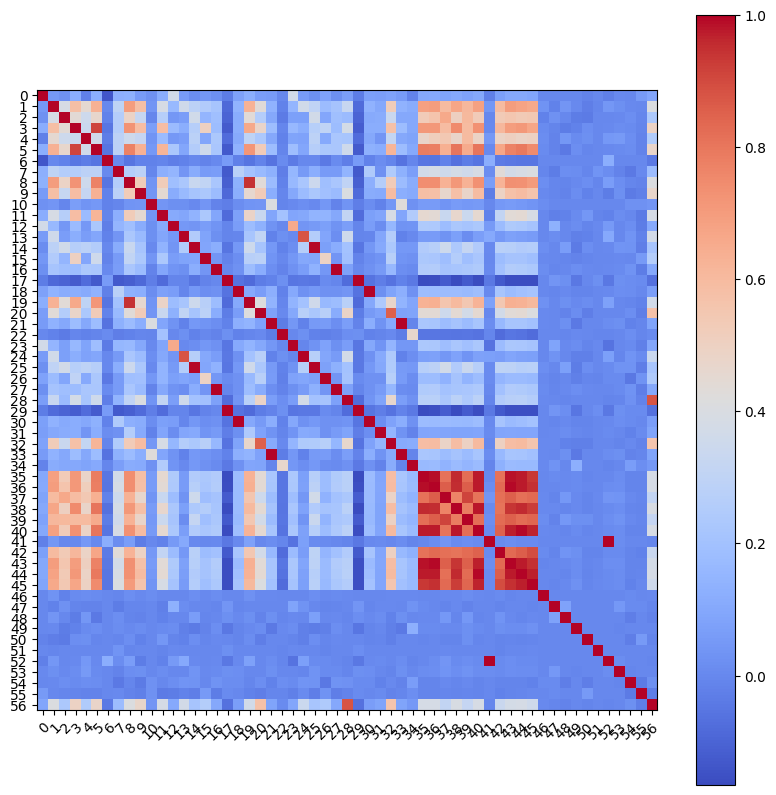

In [203]:
# create heatmap of correlation matrix
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(corr, cmap='coolwarm')
ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns)
ax.set_yticklabels(corr.columns)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
fig.colorbar(im)
plt.show()


### Alternativa de guardas como separado (no va)

In [5]:
# Split dataset
# 

from sklearn.preprocessing import MinMaxScaler

## Split train and Test
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=2,max_train_size=720,test_size=20, gap=500)

df.set_index('Time', inplace=True)
df.sort_index(inplace=True)
X = df.drop(labels=['p95 deploy/frontend'], axis=1)
y = df['p95 deploy/frontend']

In [6]:
# Normalization between 0 and 1 JUST THE FEATURES
def normalize(X_train,X_test):
    scaler_X = MinMaxScaler(feature_range=(0,1))
    X_train_normalized = pd.DataFrame(scaler_X.fit_transform(X_train.values), columns=X_train.columns)
    X_test_normalized = pd.DataFrame(scaler_X.transform(X_test.values), columns=X_test.columns)
    
    return (X_train_normalized,X_test_normalized)

In [7]:
# Training data sets
window_sizes = [20,60,120,360,720]
target_windows = [20,50,100,400,1000]

# Loop over each window size
for window_size in window_sizes:
    # Slide the window over the time series and extract training examples
    x_train = X.iloc[:window_size,:]
    y_train = y.iloc[:window_size]

    for target_window in target_windows:
        x_test = X.iloc[-target_window:,:]
        y_test = y.iloc[-target_window:]
        
        #Normalize Datasets
        x_norm_train,x_norm_test = normalize(x_train,x_test)

        #Save labels 
        df_x_test_label = pd.DataFrame(y_test)
        df_x_test = pd.DataFrame(x_norm_test)
        # Replicate indexes to be able to concatenate
        df_x_test.index = df_x_test_label.index
        
        #Save 
        dataset = pd.concat([df_x_test,df_x_test_label],axis=1)
        dataset.index.name = "date"
        path = 'Dataset/Test/'
        filename = path + 'test_{}_Train_{}_test_window.csv'.format(target_window,window_size)
        dataset.to_csv(filename)
        x_test = []
        y_test = []
    
    #Save labels 
    df_x_label = pd.DataFrame(y_train)
    df_x_train = pd.DataFrame(x_norm_train)

    # Replicate indexes to be able to concatenate
    df_x_train.index = df_x_label.index
    #Save 
    dataset = pd.concat([df_x_train,df_x_label],axis=1)
    dataset.index.name = "date"
    path = 'Dataset/Train/'
    filename = path + 'train_{}_window.csv'.format(window_size)
    dataset.to_csv(filename)
    X_train = []
    y_train = []
    

<AxesSubplot: xlabel='date'>

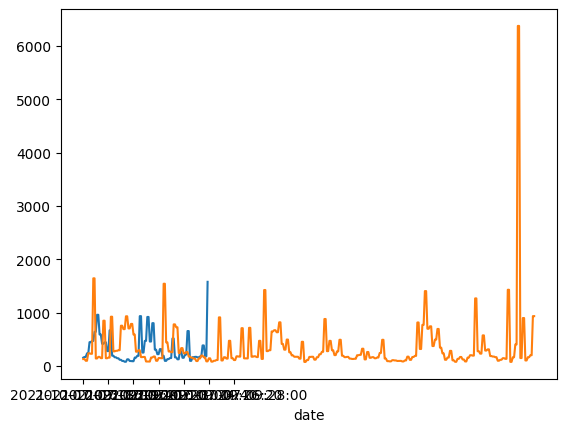

In [8]:
# SHOW AN EXAMPLE OF TRAIN AND TEST

y_train = pd.read_csv('Dataset/Train/train_360_window.csv',index_col="date")
y_test = pd.read_csv('Dataset/Test/test_100_Train_360_test_window.csv',index_col="date")
y_target_train = y_train['p95 deploy/frontend']
y_target_test = y_test['p95 deploy/frontend']
y_target_test.groupby('date').mean().plot()
y_target_train.groupby('date').mean().plot()


##

# Models

## LSTM

### Tensor Flow (FUNCIONA)

In [39]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,LSTM,Activation,Dropout
import keras.callbacks
import numpy as np
import pandas as pd

# Define input sequence length and output sequence length
input_seq_len = 20
output_seq_len = 20

# Define size of the input and output layers
input_dim = 60
output_dim = 1

#Data set
#train_df = pd.read_csv('Dataset/Train/Train_norm_full.csv', index_col=0)
train_df=pd.read_csv('/Users/emlanza/Library/CloudStorage/OneDrive-UniversidadAustral/Facultad/Maestria Data Science AUSTRAL/Tesis/Transformers-for-latency-prediction/Dataset/Train/Train_norm_full_std.csv',index_col=0)
# Define the number of samples to generate
num_samples = train_df.shape[0] - input_seq_len - output_seq_len + 1

In [31]:
train_df

,p50 deploy/adservice,p50 deploy/cartservice,p50 deploy/checkoutservice,p50 deploy/currencyservice,p50 deploy/emailservice,p50 deploy/frontend,p50 deploy/loadgenerator,p50 deploy/paymentservice,p50 deploy/productcatalogservice,p50 deploy/recommendationservice,...,deploy/currencyservice,deploy/emailservice,deploy/frontend,deploy/loadgenerator,deploy/paymentservice,deploy/productcatalogservice,deploy/recommendationservice,deploy/redis-cart,deploy/shippingservice,p95 deploy/frontend
date,,,,,,,,,,,,,,,,,,,,,
2021-10-07 09:18:00,13.460422,-1.643790,-0.057770,-0.217764,-1.146121,-0.346990,1.110223e-16,-0.644470,-0.522305,0.705090,...,-0.000017,-0.000005,-0.000005,-0.000067,-2.081668e-17,-0.000055,-0.001252,-2.081668e-17,4.805699,-0.535875
2021-10-07 09:18:05,10.031784,0.229134,-0.434722,-0.217764,-0.898530,-0.346990,1.110223e-16,-0.644470,-0.429260,0.705090,...,-0.000017,-0.000005,-0.000005,-0.000067,-2.081668e-17,-0.000055,-0.001252,-2.081668e-17,4.805699,-0.535875
2021-10-07 09:18:10,10.031784,0.229134,-0.434722,-0.228521,-0.898530,-0.393260,1.110223e-16,0.922269,-0.429260,-0.498528,...,-0.000017,-0.000005,-0.000005,-0.000067,-2.081668e-17,-0.000055,-0.001252,-2.081668e-17,-0.005351,-0.623315
2021-10-07 09:18:15,8.460325,-0.890356,-0.010651,-0.228521,-0.452866,-0.393260,1.110223e-16,0.922269,-0.592773,-0.498528,...,-0.000017,-0.000005,-0.000005,-0.000067,-2.081668e-17,-0.000055,-0.001252,-2.081668e-17,-0.005351,-0.623315
2021-10-07 09:18:20,8.460325,-0.890356,-0.010651,-0.325898,-0.452866,-0.392411,1.110223e-16,0.400022,-0.592773,-0.798506,...,-0.000017,-0.000005,-0.000005,-0.000067,-2.081668e-17,-0.000055,-0.001252,-2.081668e-17,-0.005351,-0.237772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-07 11:48:00,-0.254131,0.002309,-0.010651,-0.722205,0.587018,-0.532381,1.110223e-16,0.086675,-0.670068,-0.714562,...,-0.000017,-0.000005,-0.000005,-0.000067,-2.081668e-17,-0.000055,-2.177623,-2.081668e-17,-0.005351,-0.463400
2021-10-07 11:48:05,-0.254131,-0.166355,-0.434722,-0.722205,0.215631,-0.532381,1.110223e-16,0.086675,-0.586403,-0.714562,...,-0.000017,-0.000005,-0.000005,-0.000067,-2.081668e-17,-0.000055,-2.177623,-2.081668e-17,-0.005351,-0.463400
2021-10-07 11:48:10,-0.254131,-0.166355,-0.434722,0.248105,0.215631,-0.503038,1.110223e-16,-0.748919,-0.586403,-0.665183,...,-0.000017,-0.000005,-0.000005,-0.000067,-2.081668e-17,-0.000055,-0.001252,-2.081668e-17,-0.005351,0.627135


In [28]:
#train_df.iloc[:-5000,:]

,p50 deploy/adservice,p50 deploy/cartservice,p50 deploy/checkoutservice,p50 deploy/currencyservice,p50 deploy/emailservice,p50 deploy/frontend,p50 deploy/loadgenerator,p50 deploy/paymentservice,p50 deploy/productcatalogservice,p50 deploy/recommendationservice,...,deploy/currencyservice,deploy/emailservice,deploy/frontend,deploy/loadgenerator,deploy/paymentservice,deploy/productcatalogservice,deploy/recommendationservice,deploy/redis-cart,deploy/shippingservice,p95 deploy/frontend
date,,,,,,,,,,,,,,,,,,,,,


In [25]:
#train_df=train_df.iloc[:-5000,:]
#test_df = train_df.iloc[:5000,:]

In [32]:
train_df

,p50 deploy/adservice,p50 deploy/cartservice,p50 deploy/checkoutservice,p50 deploy/currencyservice,p50 deploy/emailservice,p50 deploy/frontend,p50 deploy/loadgenerator,p50 deploy/paymentservice,p50 deploy/productcatalogservice,p50 deploy/recommendationservice,...,deploy/currencyservice,deploy/emailservice,deploy/frontend,deploy/loadgenerator,deploy/paymentservice,deploy/productcatalogservice,deploy/recommendationservice,deploy/redis-cart,deploy/shippingservice,p95 deploy/frontend
date,,,,,,,,,,,,,,,,,,,,,
2021-10-07 09:18:00,13.460422,-1.643790,-0.057770,-0.217764,-1.146121,-0.346990,1.110223e-16,-0.644470,-0.522305,0.705090,...,-0.000017,-0.000005,-0.000005,-0.000067,-2.081668e-17,-0.000055,-0.001252,-2.081668e-17,4.805699,-0.535875
2021-10-07 09:18:05,10.031784,0.229134,-0.434722,-0.217764,-0.898530,-0.346990,1.110223e-16,-0.644470,-0.429260,0.705090,...,-0.000017,-0.000005,-0.000005,-0.000067,-2.081668e-17,-0.000055,-0.001252,-2.081668e-17,4.805699,-0.535875
2021-10-07 09:18:10,10.031784,0.229134,-0.434722,-0.228521,-0.898530,-0.393260,1.110223e-16,0.922269,-0.429260,-0.498528,...,-0.000017,-0.000005,-0.000005,-0.000067,-2.081668e-17,-0.000055,-0.001252,-2.081668e-17,-0.005351,-0.623315
2021-10-07 09:18:15,8.460325,-0.890356,-0.010651,-0.228521,-0.452866,-0.393260,1.110223e-16,0.922269,-0.592773,-0.498528,...,-0.000017,-0.000005,-0.000005,-0.000067,-2.081668e-17,-0.000055,-0.001252,-2.081668e-17,-0.005351,-0.623315
2021-10-07 09:18:20,8.460325,-0.890356,-0.010651,-0.325898,-0.452866,-0.392411,1.110223e-16,0.400022,-0.592773,-0.798506,...,-0.000017,-0.000005,-0.000005,-0.000067,-2.081668e-17,-0.000055,-0.001252,-2.081668e-17,-0.005351,-0.237772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-07 11:48:00,-0.254131,0.002309,-0.010651,-0.722205,0.587018,-0.532381,1.110223e-16,0.086675,-0.670068,-0.714562,...,-0.000017,-0.000005,-0.000005,-0.000067,-2.081668e-17,-0.000055,-2.177623,-2.081668e-17,-0.005351,-0.463400
2021-10-07 11:48:05,-0.254131,-0.166355,-0.434722,-0.722205,0.215631,-0.532381,1.110223e-16,0.086675,-0.586403,-0.714562,...,-0.000017,-0.000005,-0.000005,-0.000067,-2.081668e-17,-0.000055,-2.177623,-2.081668e-17,-0.005351,-0.463400
2021-10-07 11:48:10,-0.254131,-0.166355,-0.434722,0.248105,0.215631,-0.503038,1.110223e-16,-0.748919,-0.586403,-0.665183,...,-0.000017,-0.000005,-0.000005,-0.000067,-2.081668e-17,-0.000055,-0.001252,-2.081668e-17,-0.005351,0.627135


In [44]:
train_df_norm, test_df_norm =normalize(train_df, test_df)

In [40]:
num_samples = train_df_norm.shape[0] - input_seq_len - output_seq_len + 1

NameError: name 'train_df_norm' is not defined

In [38]:
train_input_seq.shape

(1410, 360, 60)

In [41]:
# Create the input/output pairs for training
train_input_seq = np.zeros((num_samples, input_seq_len, train_df.shape[1]))
train_output_seq = np.zeros((num_samples, output_seq_len, 1))

for i in range(num_samples):
    train_input_seq[i] = train_df[i:i+input_seq_len]
    train = train_df.iloc[i+input_seq_len:i+input_seq_len+output_seq_len,-1].values
    train_output_seq[i] = train.reshape(-1,1)

In [42]:

# design network
model_1 = Sequential()
model_1.add(LSTM(128,return_sequences=True, input_shape=(train_input_seq.shape[1], train_input_seq.shape[2])))
model_1.add(LSTM(64))
model_1.add(Dropout(0.3))
model_1.add(Dense(train_output_seq.shape[1]))
model_1.compile(loss='mse', optimizer='adam', metrics=['mse']) #changed from ['mse']

callback = [keras.callbacks.EarlyStopping(monitor='mse', patience=2)]  

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 20, 128)           96768     
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 20)                1300      
                                                                 
Total params: 147,476
Trainable params: 147,476
Non-trainable params: 0
_________________________________________________________________


Epoch 1/35
18/18 - 1s - loss: 0.6738 - mse: 0.6738 - 646ms/epoch - 36ms/step
Epoch 2/35
18/18 - 1s - loss: 0.6475 - mse: 0.6475 - 609ms/epoch - 34ms/step
Epoch 3/35
18/18 - 1s - loss: 0.6315 - mse: 0.6315 - 583ms/epoch - 32ms/step
Epoch 4/35
18/18 - 1s - loss: 0.6242 - mse: 0.6242 - 588ms/epoch - 33ms/step
Epoch 5/35
18/18 - 1s - loss: 0.6155 - mse: 0.6155 - 575ms/epoch - 32ms/step
Epoch 6/35
18/18 - 1s - loss: 0.6060 - mse: 0.6060 - 626ms/epoch - 35ms/step
Epoch 7/35
18/18 - 1s - loss: 0.5874 - mse: 0.5874 - 563ms/epoch - 31ms/step
Epoch 8/35
18/18 - 1s - loss: 0.5736 - mse: 0.5736 - 562ms/epoch - 31ms/step
Epoch 9/35
18/18 - 1s - loss: 0.5670 - mse: 0.5670 - 563ms/epoch - 31ms/step
Epoch 10/35
18/18 - 1s - loss: 0.5832 - mse: 0.5832 - 571ms/epoch - 32ms/step
Epoch 11/35
18/18 - 1s - loss: 0.6431 - mse: 0.6431 - 575ms/epoch - 32ms/step


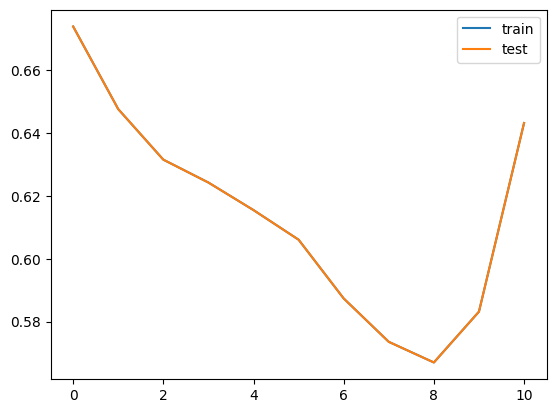

In [44]:
# fit network
history = model_1.fit(train_input_seq, train_output_seq, epochs=35, batch_size=100, verbose=2, shuffle=False,callbacks=[callback])

# plot history
plt.plot(history.history['mse'], label='train')
plt.plot(history.history['loss'], label='test')
plt.legend()
plt.show()

In [47]:
# LOAD TEST DATA SET 
path = "/Users/emlanza/Library/CloudStorage/OneDrive-UniversidadAustral/Facultad/Maestria Data Science AUSTRAL/Tesis/Transformers-for-latency-prediction/Dataset/Test/Test_norm_full_std.csv"

test_df=pd.read_csv(path,index_col=0)

# Define the number of samples to generate
num_samples = test_df.shape[0] - input_seq_len - output_seq_len + 1

In [153]:
## TEST
#test_df = pd.read_csv('Dataset/Test/Test_norm_full.csv', index_col=0)
#test_df.shape

(500, 55)

In [41]:
#train_df_norm.to_csv('Dataset/Train/Train_etth_norm.csv')
#test_df_norm.to_csv('Dataset/Test/Test_etth_norm.csv')

In [53]:
# Create the input/output pairs for training
num_samples = test_df.shape[0] - input_seq_len - output_seq_len + 1
test_input_seq = np.zeros((num_samples, input_seq_len, test_df.shape[1]))
test_output_seq = np.zeros((num_samples, output_seq_len, 1))

for i in range(num_samples):
    test_input_seq[i] = test_df[i:i+input_seq_len]
    test = test_df.iloc[i+input_seq_len:i+input_seq_len+output_seq_len,-1].values
    test_output_seq[i] = test.reshape(-1,1)

In [48]:
# Create the input/output pairs for training
#num_samples = test_df.shape[2] - input_seq_len - output_seq_len + 1
#test_input_seq = np.zeros((num_samples, input_seq_len, test_df.shape[2]))
#test_output_seq = np.zeros((num_samples, output_seq_len, 1))

#for i in range(num_samples):
#    test_input_seq[i] = test_df[i:i+input_seq_len]
#    test = test_df.iloc[i+input_seq_len:i+input_seq_len+output_seq_len,-1].values
#    test_output_seq[i] = test.reshape(-1,1)

IndexError: tuple index out of range

In [98]:
test_input_seq[2].shape[0]

20

In [105]:
test_input_seq.shape[0]

461

(1, 20, 60)
1/1 [==============================] - 0s 25ms/step
MSE Value : 0.8596065084461625


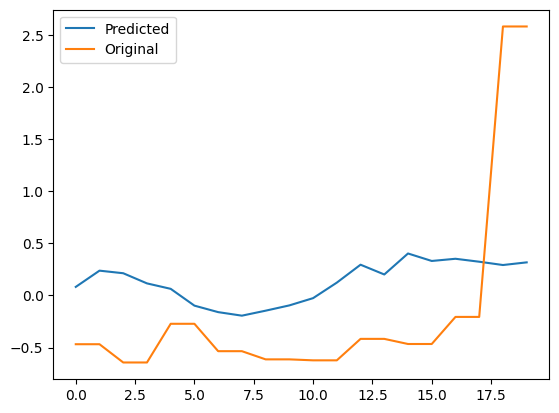

In [102]:
## Predict 
test=test_input_seq[1].reshape((1,test_input_seq[2].shape[0], test_input_seq[3].shape[1]))
print(test.shape)

# Predict the output for a new input sequence
#new_input_data = np.random.rand(1, input_seq_len, input_dim)
predicted_output = model_1.predict(test)

predicted_output= predicted_output.reshape(20,1)
original_output = test_output_seq[1]
# plot original vs predicted values
plt.plot(predicted_output, label='Predicted')
plt.plot(original_output[:,0], label='Original')
print("MSE Value :" ,mean_squared_error(predicted_output, original_output))
plt.legend()
plt.show()

In [113]:
#Lets iterate on every array to summarize de MSE value
for i,x in enumerate(test_input_seq):
# Predict the output for a new input sequence
    print(x.shape[2])
    test = x.reshape(1,x[0].shape[0],x[1].shape[0])
    
#new_input_data = np.random.rand(1, input_seq_len, input_dim)
    predicted_output = model_1.predict(x)

    predicted_output= predicted_output.reshape(20,1)
    original_output = test_output_seq[i]

    print("MSE Value :" ,mean_squared_error(predicted_output, original_output))

IndexError: tuple index out of range

### PyTorch

In [5]:
import pandas as pd
import torch

In [4]:
df = pd.read_csv("Dataset/Train/Train_norm_full.csv")

df.head()

,date,p50 deploy/adservice,p50 deploy/cartservice,p50 deploy/checkoutservice,p50 deploy/currencyservice,p50 deploy/emailservice,p50 deploy/frontend,p50 deploy/paymentservice,p50 deploy/productcatalogservice,p50 deploy/recommendationservice,...,deploy/cartservice,deploy/checkoutservice,deploy/currencyservice,deploy/emailservice,deploy/frontend,deploy/loadgenerator,deploy/productcatalogservice,deploy/recommendationservice,deploy/shippingservice,p95 deploy/frontend
0,2021-10-07 09:18:00,13.460422,-1.643790,-0.057770,-0.217764,-1.146121,-0.346990,-0.644470,-0.522305,0.705090,...,-0.000056,-0.000104,-0.000017,-0.000005,-0.000005,-0.000067,-0.000055,-0.001252,4.805699,-0.535875
1,2021-10-07 09:18:05,10.031784,0.229134,-0.434722,-0.217764,-0.898530,-0.346990,-0.644470,-0.429260,0.705090,...,-0.000056,-0.000104,-0.000017,-0.000005,-0.000005,-0.000067,-0.000055,-0.001252,4.805699,-0.535875
2,2021-10-07 09:18:10,10.031784,0.229134,-0.434722,-0.228521,-0.898530,-0.393260,0.922269,-0.429260,-0.498528,...,-0.000056,-0.000104,-0.000017,-0.000005,-0.000005,-0.000067,-0.000055,-0.001252,-0.005351,-0.623315
3,2021-10-07 09:18:15,8.460325,-0.890356,-0.010651,-0.228521,-0.452866,-0.393260,0.922269,-0.592773,-0.498528,...,-0.000056,-0.000104,-0.000017,-0.000005,-0.000005,-0.000067,-0.000055,-0.001252,-0.005351,-0.623315
4,2021-10-07 09:18:20,8.460325,-0.890356,-0.010651,-0.325898,-0.452866,-0.392411,0.400022,-0.592773,-0.798506,...,-0.000056,-0.000104,-0.000017,-0.000005,-0.000005,-0.000067,-0.000055,-0.001252,-0.005351,-0.237772


In [ ]:
## I need to generate secuences, if i have (1,2,3,4,5,6) and my train_wind =3 and pred win=1, i will need to prepare the data set to have samples in the format (1,2,3)->4..(2,3,4)-> and so on. 

In [ ]:
trainin_window    = 360 
prediction_window = 36

# Defining a function that creates sequences and targets as shown above
def generate_sequences(df: pd.DataFrame, tw: int, pw: int, target_columns, drop_targets=False):
  '''
  df: Pandas DataFrame of the univariate time-series
  tw: Training Window - Integer defining how many steps to look back
  pw: Prediction Window - Integer defining how many steps forward to predict

  returns: dictionary of sequences and targets for all sequences
  '''
  data = dict() # Store results into a dictionary
  L = len(df)
  for i in range(L-tw):
    # Option to drop target from dataframe
    if drop_targets:
      df.drop(target_columns, axis=1, inplace=True)

    # Get current sequence  
    sequence = df[i:i+tw].values
    # Get values right after the current sequence
    target = df[i+tw:i+tw+pw][target_columns].values
    data[i] = {'sequence': sequence, 'target': target}
  return data

In [ ]:
class SequenceDataset(Dataset):

  def __init__(self, df):
    self.data = df
    num_df = len(df)
    border1=
    border2=[num_df,]
    df_raw = df_raw[['date']+cols+[self.target]]

  def __getitem__(self, idx):
    sample = self.data[idx]
    return torch.Tensor(sample['sequence']), torch.Tensor(sample['target'])
  
  def __len__(self):
    return len(self.data)

In [ ]:
df_raw = df_raw[['date']+cols+[self.target]]

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd

In [146]:
# define dataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, data, input_size, output_size, target_col):
        self.data = data
        self.input_size = input_size
        self.output_size = output_size
        self.target_col = target_col

    def __len__(self):
        return len(self.data) - self.input_size - self.output_size + 1

    def __getitem__(self, idx):
        input_seq = self.data[idx:idx+self.input_size, :]
        output_seq = self.data[idx+self.input_size:idx+self.input_size+self.output_size, self.target_col]
        return torch.tensor(input_seq, dtype=torch.float32), torch.tensor(output_seq, dtype=torch.float32)

In [70]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=5):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [147]:
# read data and set hyperparameters
train_df = pd.read_csv('Dataset/Train/Train_norm_full.csv', index_col=0)
input_size = 100
output_size = 20
hidden_size = 64
num_epochs = 50
learning_rate = 0.1
target_col = 59  # set the index of the target featuree)

In [93]:
##LOOP
input_sizes = [20,60,120,360,500]
output_sizes = [20,50,100,400,1000]
for input_size in input_sizes:
    for output_size in output_sizes:
        # initialize dataset and data loader
        dataset = TimeSeriesDataset(train_df.values, input_size, output_size, target_col)
        data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

        # initialize model and optimizer
        model = LSTM(train_df.shape[1], hidden_size, output_size)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        for epoch in range(num_epochs):
            epoch_loss = 0.0
            epoch_mse = 0.0
            for input_seq, output_seq in data_loader:
                optimizer.zero_grad()
                model.hidden = (torch.zeros(1, 1, hidden_size), torch.zeros(1, 1, hidden_size))
                output = model(input_seq)
                loss = criterion(output, output_seq.unsqueeze(-1))
                mse_loss = nn.MSELoss()(output, output_seq.unsqueeze(-1))
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
                epoch_mse += mse_loss.item()
            #print('Epoch {}/{} Loss: {} MSE: {}'.format(epoch+1, num_epochs, epoch_loss/len(data_loader), epoch_mse/len(data_loader)))
        
        # Test
        # Initialize dataset and data loader
        test_dataset = TimeSeriesDataset(test_df.values, input_size, output_size,target_col=59)
        test_data_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

        # Set model to evaluation mode
        model.eval()

        # Calculate MSE on test data
        mse = 0
        with torch.no_grad():
            for input_seq, output_seq in test_data_loader:
                model.hidden = (torch.zeros(1, 1, hidden_size), torch.zeros(1, 1, hidden_size))
                output = model(input_seq)
                mse += criterion(output, output_seq.unsqueeze(-1)).item()

        mse /= len(test_data_loader)
        print('MSE on test data: {:.6f}'.format(mse), "Input: ",input_size, "Output: ",output_size)
        #Evaluate
        # plot original vs predicted values
        plt.plot(output.squeeze().detach().numpy(), label='Predicted')
        plt.plot(output_seq.squeeze().detach().numpy(), label='Original')
        plt.legend()
        plt.show()
        #Save on file

        


KeyboardInterrupt: 

In [149]:
# initialize dataset and data loader
dataset = TimeSeriesDataset(train_df.values, input_size, output_size, target_col)
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

# initialize model and optimizer
model = LSTM(train_df.shape[1], hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [73]:
# train model
for epoch in range(num_epochs):
    epoch_loss = 0.0
    epoch_mse = 0.0
    for input_seq, output_seq in data_loader:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1, 1, hidden_size), torch.zeros(1, 1, hidden_size))
        output = model(input_seq)
        loss = criterion(output, output_seq.unsqueeze(-1))
        mse_loss = nn.MSELoss()(output, output_seq.unsqueeze(-1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_mse += mse_loss.item()
    print('Epoch {}/{} Loss: {} MSE: {}'.format(epoch+1, num_epochs, epoch_loss/len(data_loader), epoch_mse/len(data_loader)))

/opt/homebrew/Caskroom/miniforge/base/envs/GIG/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 20, 1])) that is different to the input size (torch.Size([1, 20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor([[ 0.0049,  0.0287,  0.0323,  0.0322,  0.0295,  0.0329,  0.0246,  0.0215,
          0.0322,  0.0411,  0.0222,  0.0329,  0.0319,  0.0365,  0.0120,  0.0330,
          0.0309, -0.0242,  0.0310,  0.0330]], grad_fn=<AddmmBackward0>)
Epoch 1/20 Loss: 0.003013942683778197 MSE: 0.003013942683778197
tensor([[-7.8042e-02,  3.5050e-02,  5.1410e-02,  4.7193e-02,  1.4355e-01,
          1.1833e-01, -1.0638e-02, -6.4091e-03,  1.3425e-02, -1.0277e-02,
          4.7382e-02,  2.3141e-02, -1.2855e-02, -1.6806e-02,  4.0042e-03,
          1.2869e-02, -1.3244e-02,  1.0185e-01, -5.2452e-06,  7.5916e-03]],
       grad_fn=<AddmmBackward0>)
Epoch 2/20 Loss: 0.008183376689821682 MSE: 0.008183376689821682


KeyboardInterrupt: 

#### Test

In [76]:
# Load test data
test_df = pd.read_csv('Dataset/Test/Test_norm_full.csv', index_col=0)

# Initialize dataset and data loader
test_dataset = TimeSeriesDataset(test_df.values, input_size, output_size,target_col=59)
test_data_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Set model to evaluation mode
model.eval()

# Calculate MSE on test data
mse = 0
with torch.no_grad():
    for input_seq, output_seq in test_data_loader:
        model.hidden = (torch.zeros(1, 1, hidden_size), torch.zeros(1, 1, hidden_size))
        output = model(input_seq)
        mse += criterion(output, output_seq.unsqueeze(-1)).item()

mse /= len(test_data_loader)
print('MSE on test data: {:.6f}'.format(mse))

/opt/homebrew/Caskroom/miniforge/base/envs/GIG/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 20, 1])) that is different to the input size (torch.Size([1, 20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


MSE on test data: 0.004128


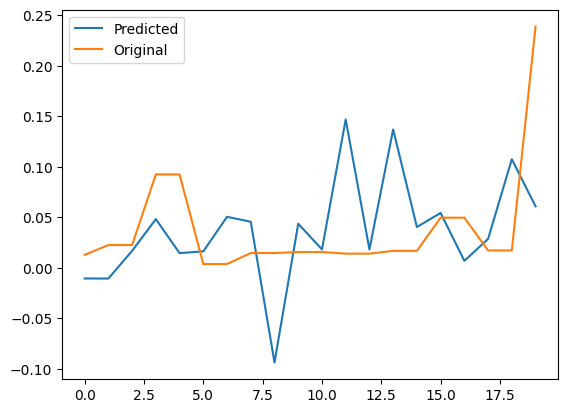

In [77]:
import matplotlib.pyplot as plt

# plot original vs predicted values
plt.plot(output.squeeze().detach().numpy(), label='Predicted')
plt.plot(output_seq.squeeze().detach().numpy(), label='Original')
plt.legend()
plt.show()

## LSTM Seq2Seq ( TF )

In [597]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense

In [600]:
# Define input sequence length and output sequence length
input_seq_len = 40
output_seq_len = 50

# Define size of the input and output layers
input_dim = 60
output_dim = 1

In [599]:
# Define the number of units in the LSTM layer
num_units = 50

In [601]:
# Define the number of units in the LSTM layer
num_units = 256

# Define the input layer
encoder_inputs = Input(shape=(input_seq_len, input_dim))

In [602]:
# Define the encoder LSTM layer
encoder_lstm = LSTM(num_units, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

In [612]:
# Discard encoder_outputs and only keep the states.
encoder_states = [state_h, state_c]

# Define the decoder inputs and outputs
decoder_inputs = Input(shape=(output_seq_len, output_dim))
decoder_lstm = LSTM(num_units,
                    return_sequences=True,
                    dropout = 0.4,
                    recurrent_dropout=0.4 ,
                    return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(output_dim, activation='linear')
decoder_outputs = decoder_dense(decoder_outputs)

In [604]:
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None, 40, 60)]     0           []                               
                                                                                                  
 input_31 (InputLayer)          [(None, 50, 1)]      0           []                               
                                                                                                  
 lstm_31 (LSTM)                 [(None, 4),          1040        ['input_30[0][0]']               
                                 (None, 4),                                                       
                                 (None, 4)]                                                       
                                                                                           

In [605]:
# Define the Seq2Seq model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

In [606]:
#Data set
train_df = pd.read_csv('Dataset/Train/Train_norm_full.csv', index_col=0)

# Define the number of samples to generate
num_samples = train_df.shape[0] - input_seq_len - output_seq_len + 1

In [613]:
# Create the input/output pairs for training
train_input_seq = np.zeros((num_samples, input_seq_len, train_df.shape[1]))
train_output_seq = np.zeros((num_samples, output_seq_len, 1))

for i in range(num_samples):
    train_input_seq[i] = train_df[i:i+input_seq_len]
    train = train_df.iloc[i+input_seq_len:i+input_seq_len+output_seq_len,-1].values
    train_output_seq[i] = train.reshape(-1,1)

In [614]:
# Train the model
model.fit([train_input_seq, train_output_seq], train_output_seq[:, :, 0], epochs=15, batch_size=40)

Epoch 1/15
43/43 [==============================] - 4s 98ms/step - loss: 1.6426e-06 - mse: 1.6426e-06
Epoch 2/15
43/43 [==============================] - 5s 105ms/step - loss: 1.4438e-06 - mse: 1.4438e-06
Epoch 3/15
43/43 [==============================] - 4s 94ms/step - loss: 1.2689e-06 - mse: 1.2689e-06
Epoch 4/15
43/43 [==============================] - 4s 93ms/step - loss: 1.1131e-06 - mse: 1.1131e-06
Epoch 5/15
43/43 [==============================] - 4s 93ms/step - loss: 9.7080e-07 - mse: 9.7080e-07
Epoch 6/15
43/43 [==============================] - 4s 94ms/step - loss: 8.5316e-07 - mse: 8.5316e-07
Epoch 7/15
43/43 [==============================] - 5s 110ms/step - loss: 7.5226e-07 - mse: 7.5226e-07
Epoch 8/15
43/43 [==============================] - 5s 105ms/step - loss: 6.5160e-07 - mse: 6.5160e-07
Epoch 9/15
43/43 [==============================] - 4s 101ms/step - loss: 5.6951e-07 - mse: 5.6951e-07
Epoch 10/15
43/43 [==============================] - 4s 101ms/step - loss: 4.9

1/1 [==============================] - 0s 442ms/step


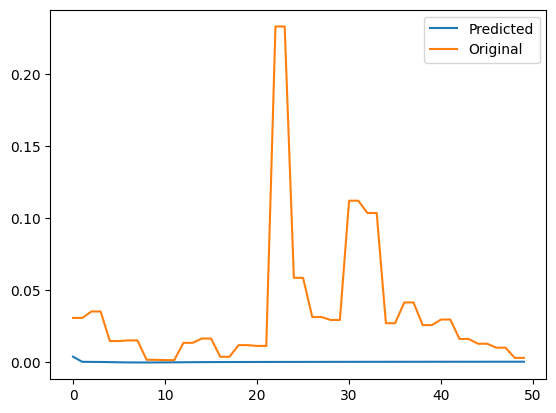

In [610]:
## Predict 
test=train_input_seq[2].reshape((1,train_input_seq[2].shape[0], train_input_seq[3].shape[1]))
test.shape

# Predict the output for a new input sequence
#new_input_data = np.random.rand(1, input_seq_len, input_dim)
predicted_output = model.predict([test, np.zeros((1, output_seq_len, output_dim))])

predicted_output= predicted_output.reshape(50,1)
original_output = train_output_seq[2]

# plot original vs predicted values
plt.plot(predicted_output[:,0], label='Predicted')
plt.plot(original_output[:,0], label='Original')
plt.legend()
plt.show()

## Vanilla

In [6]:
import torch
import torch.nn as nn
import math

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_size, output_size, num_layers, num_heads, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()

        self.embedding_size = input_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.dropout = nn.Dropout(dropout)

        # Positional encoding
        self.pos_encoder = PositionalEncoding(input_size)

        # Transformer layers
        self.transformer_layers = nn.ModuleList([nn.TransformerEncoderLayer(d_model=input_size, nhead=num_heads, dropout=dropout) for _ in range(num_layers)])
        
        # Output layer
        self.output_layer = nn.Linear(input_size, output_size)

    def forward(self, input):
        # Add positional encoding
        input = self.pos_encoder(input)
        
        # Pass through transformer layers
        for layer in self.transformer_layers:
            input = layer(input)
        
        # Flatten and pass through output layer
        input = input.flatten(start_dim=1)
        output = self.output_layer(input)
        
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=10000):
        super(PositionalEncoding, self).__init__()

        # Compute positional encodings
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # Register buffer
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x


In [10]:
import torch
import torch.nn as nn
import numpy as np

# Create a time series dataset
time_series = np.random.rand(100, 60)
target = np.random.rand(100, 1)

# Convert data to PyTorch tensors
time_series_tensor = torch.tensor(time_series, dtype=torch.float32).unsqueeze(2)  # Add third dimension
target_tensor = torch.tensor(target, dtype=torch.float32)

# Create a TimeSeriesTransformer model
model = TimeSeriesTransformer(input_size=60, output_size=1, num_layers=2, num_heads=4)

# Add a linear layer to map from transformer output to target output
model.fc = nn.Linear(3600, 1)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    # Forward pass
    output = model(time_series_tensor)
    output = output.flatten(start_dim=1)  # Flatten output

    # Compute loss
    loss = criterion(output, target_tensor)

    # Backward pass and optimization step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print("Epoch [{}/{}], Loss: {:.4f}".format(epoch+1, num_epochs, loss.item()))



RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x3600 and 60x1)

## Informer

In [3]:
import sys
import os
sys.path.append('/Users/emlanza/Library/CloudStorage/OneDrive-UniversidadAustral/Facultad/Maestria Data Science AUSTRAL/Tesis/Transformers-for-latency-prediction/Informer/Informer2020')

In [7]:
# Carga de dataset
ds = pd.read_csv("/Users/emlanza/Library/CloudStorage/OneDrive-UniversidadAustral/Facultad/Maestria Data Science AUSTRAL/Tesis/Transformers-for-latency-prediction/Dataset/Train/Train_norm_full.csv")
ds

,date,p50 deploy/adservice,p50 deploy/cartservice,p50 deploy/checkoutservice,p50 deploy/currencyservice,p50 deploy/emailservice,p50 deploy/frontend,p50 deploy/paymentservice,p50 deploy/productcatalogservice,p50 deploy/recommendationservice,...,deploy/cartservice,deploy/checkoutservice,deploy/currencyservice,deploy/emailservice,deploy/frontend,deploy/loadgenerator,deploy/productcatalogservice,deploy/recommendationservice,deploy/shippingservice,p95 deploy/frontend
0,2021-10-07 09:18:00,13.460422,-1.643790,-0.057770,-0.217764,-1.146121,-0.346990,-0.644470,-0.522305,0.705090,...,-0.000056,-0.000104,-0.000017,-0.000005,-0.000005,-0.000067,-0.000055,-0.001252,4.805699,-0.535875
1,2021-10-07 09:18:05,10.031784,0.229134,-0.434722,-0.217764,-0.898530,-0.346990,-0.644470,-0.429260,0.705090,...,-0.000056,-0.000104,-0.000017,-0.000005,-0.000005,-0.000067,-0.000055,-0.001252,4.805699,-0.535875
2,2021-10-07 09:18:10,10.031784,0.229134,-0.434722,-0.228521,-0.898530,-0.393260,0.922269,-0.429260,-0.498528,...,-0.000056,-0.000104,-0.000017,-0.000005,-0.000005,-0.000067,-0.000055,-0.001252,-0.005351,-0.623315
3,2021-10-07 09:18:15,8.460325,-0.890356,-0.010651,-0.228521,-0.452866,-0.393260,0.922269,-0.592773,-0.498528,...,-0.000056,-0.000104,-0.000017,-0.000005,-0.000005,-0.000067,-0.000055,-0.001252,-0.005351,-0.623315
4,2021-10-07 09:18:20,8.460325,-0.890356,-0.010651,-0.325898,-0.452866,-0.392411,0.400022,-0.592773,-0.798506,...,-0.000056,-0.000104,-0.000017,-0.000005,-0.000005,-0.000067,-0.000055,-0.001252,-0.005351,-0.237772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1800,2021-10-07 11:48:00,-0.254131,0.002309,-0.010651,-0.722205,0.587018,-0.532381,0.086675,-0.670068,-0.714562,...,-0.000056,-0.000104,-0.000017,-0.000005,-0.000005,-0.000067,-0.000055,-2.177623,-0.005351,-0.463400
1801,2021-10-07 11:48:05,-0.254131,-0.166355,-0.434722,-0.722205,0.215631,-0.532381,0.086675,-0.586403,-0.714562,...,-0.000056,-0.000104,-0.000017,-0.000005,-0.000005,-0.000067,-0.000055,-2.177623,-0.005351,-0.463400
1802,2021-10-07 11:48:10,-0.254131,-0.166355,-0.434722,0.248105,0.215631,-0.503038,-0.748919,-0.586403,-0.665183,...,-0.000056,-0.000104,-0.000017,-0.000005,-0.000005,-0.000067,-0.000055,-0.001252,-0.005351,0.627135
1803,2021-10-07 11:48:15,0.031589,0.688184,0.554777,0.248105,-0.650939,-0.503038,-0.748919,-0.471991,-0.665183,...,-0.000056,-0.000104,-0.000017,-0.000005,-0.000005,-0.000067,-0.000055,-0.001252,-0.005351,0.627135


In [4]:
from data.data_loader import Dataset_Custom
from utils.tools import dotdict
from exp.exp_informer import Exp_Informer
from torch.utils.data import DataLoader
import pandas as pd
import torch
import os

args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'train_norm' # data
args.root_path = './Dataset/Train/' # root path of data file
args.data_path = 'train_norm_full.csv' # data file
args.features = 'MS' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'p95 deploy/frontend' # target feature in S or MS task
args.freq = 't' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 400 # input sequence length of Informer encoder
args.label_len = 360 # start token length of Informer decoder
args.pred_len = 36 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 56 # encoder input size
args.dec_in = 56 # decoder input size
args.c_out = 10 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.scale = False

args.batch_size = 32 
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 6
args.patience = 3
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'

In [3]:
Data = Dataset_Custom
timeenc = 0 if args.embed!='timeF' else 1
flag = 'train'; shuffle_flag = False; drop_last = True; batch_size = 1

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    timeenc=timeenc,
    target=args.target, # HULL here
    freq=args.freq # 'h': hourly, 't':minutely
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

In [5]:
args.detail_freq = args.freq
args.freq = args.freq[-1:]

print('Args in experiment:')
print(args)

Args in experiment:
{'model': 'informer', 'data': 'train_norm', 'root_path': './Dataset/Train/', 'data_path': 'train_norm_full.csv', 'features': 'MS', 'target': 'p95 deploy/frontend', 'freq': 't', 'checkpoints': './informer_checkpoints', 'seq_len': 400, 'label_len': 360, 'pred_len': 36, 'enc_in': 56, 'dec_in': 56, 'c_out': 10, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'output_attention': False, 'mix': True, 'padding': 0, 'scale': False, 'batch_size': 32, 'learning_rate': 0.0001, 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'num_workers': 0, 'itr': 1, 'train_epochs': 6, 'patience': 3, 'des': 'exp', 'use_gpu': False, 'gpu': 0, 'use_multi_gpu': False, 'devices': '0,1,2,3', 'detail_freq': 't'}


In [6]:
Exp = Exp_Informer

for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features, 
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)

    # set experiments
    exp = Exp(args)
    
    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)
    
    # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)

Use CPU
>>>>>>>start training : informer_train_norm_ftMS_sl400_ll360_pl36_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch: 1 cost time: 413.59610080718994
Epoch: 1, Steps: 25 | Train Loss: 0.6266106 Vali Loss: nan Test Loss: nan
Validation loss decreased (inf --> nan).  Saving model ...
Updating learning rate to 0.0001
Epoch: 2 cost time: 383.54681181907654
Epoch: 2, Steps: 25 | Train Loss: 0.5849778 Vali Loss: nan Test Loss: nan
Validation loss decreased (nan --> nan).  Saving model ...
Updating learning rate to 5e-05
Epoch: 3 cost time: 382.81328892707825
Epoch: 3, Steps: 25 | Train Loss: 0.5629053 Vali Loss: nan Test Loss: nan
Validation loss decreased (nan --> nan).  Saving model ...
Updating learning rate to 2.5e-05
Epoch: 4 cost time: 381.98262000083923


KeyboardInterrupt: 

### Prediction


In [189]:
import os

# set saved model path
setting = 'informer_train_norm_ftMS_sl1000_ll24_pl100_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
# path = os.path.join(args.checkpoints,setting,'checkpoint.pth')

In [185]:
# If you already have a trained model, you can set the arguments and model path, then initialize a Experiment and use it to predict
# Prediction is a sequence which is adjacent to the last date of the data, and does not exist in the data
# If you want to get more information about prediction, you can refer to code `exp/exp_informer.py function predict()` and `data/data_loader.py class Dataset_Pred`
Exp = Exp_Informer
exp = Exp(args)

Use CPU


In [80]:
pred= exp.predict(setting, True)

TypeError: 'NoneType' object is not subscriptable

In [24]:
pred

NameError: name 'pred' is not defined

In [190]:
import numpy as np
preds = np.load('./results/'+setting+'/pred.npy')
trues = np.load('./results/'+setting+'/true.npy')

# [samples, pred_len, dimensions]
preds.shape, trues.shape

((256, 100, 1), (256, 100, 1))

In [192]:
preds[0,:,-1]

array([0.29334328, 0.29332662, 0.29332647, 0.29332662, 0.29332677,
       0.2933267 , 0.29332682, 0.29618424, 0.29691404, 0.29287386,
       0.2970682 , 0.29706812, 0.29706827, 0.29706824, 0.29706827,
       0.29706818, 0.29706794, 0.297068  , 0.29706788, 0.29706794,
       0.29706788, 0.2970678 , 0.29950404, 0.2916433 , 0.2944455 ,
       0.29377288, 0.29437038, 0.29437032, 0.29437032, 0.29437035,
       0.29437023, 0.29437026, 0.29437006, 0.2943702 , 0.2943703 ,
       0.29437026, 0.29437047, 0.29437026, 0.301556  , 0.30144757,
       0.2903234 , 0.3013777 , 0.3013776 , 0.30137774, 0.30137756,
       0.3013777 , 0.3013776 , 0.3013775 , 0.30137742, 0.30137748,
       0.30137748, 0.30137748, 0.3013775 , 0.30015287, 0.2905231 ,
       0.2959266 , 0.2930369 , 0.29343587, 0.293436  , 0.29343587,
       0.29343587, 0.29343605, 0.29343593, 0.29343602, 0.29343578,
       0.29343584, 0.29343593, 0.29343593, 0.29343587, 0.2945404 ,
       0.2954577 , 0.2942239 , 0.29558873, 0.29558867, 0.29558

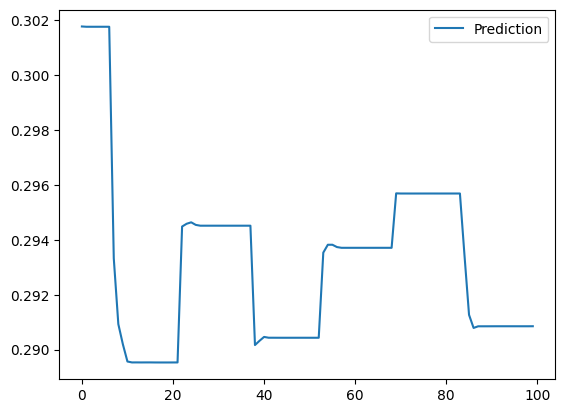

In [193]:
# draw OT prediction
import matplotlib.pyplot as plt
plt.figure()
#plt.plot(trues[250,:,-1], label='GroundTruth')
plt.plot(preds[250,:,-1], label='Prediction')
plt.legend()
plt.show()

In [28]:
# here is the detailed code of function predict

def predict(exp, setting, load=False):
    pred_data, pred_loader = exp._get_data(flag='pred')
        
    if load:
        path = os.path.join(exp.args.checkpoints, setting)
        best_model_path = path+'/'+'checkpoint.pth'
        exp.model.load_state_dict(torch.load(best_model_path))

    exp.model.eval()
        
    preds = []
        
    for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(pred_loader):
        batch_x = batch_x.float().to(exp.device)
        batch_y = batch_y.float()
        batch_x_mark = batch_x_mark.float().to(exp.device)
        batch_y_mark = batch_y_mark.float().to(exp.device)

        # decoder input
        if exp.args.padding==0:
            dec_inp = torch.zeros([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        elif exp.args.padding==1:
            dec_inp = torch.ones([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        else:
            dec_inp = torch.zeros([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        dec_inp = torch.cat([batch_y[:,:exp.args.label_len,:], dec_inp], dim=1).float().to(exp.device)
        # encoder - decoder
        if exp.args.use_amp:
            with torch.cuda.amp.autocast():
                if exp.args.output_attention:
                    outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                else:
                    outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        else:
            if exp.args.output_attention:
                outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
            else:
                outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        f_dim = -1 if exp.args.features=='MS' else 0
        batch_y = batch_y[:,-exp.args.pred_len:,f_dim:].to(exp.device)
        
        pred = outputs.detach().cpu().numpy()#.squeeze()
        
        preds.append(pred)

    preds = np.array(preds)
    preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
    
    # result save
    folder_path = './results/' + setting +'/'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    np.save(folder_path+'real_prediction.npy', preds)
    
    return preds


In [29]:
# you can also use this prediction function to get result
prediction = predict(exp, setting, True)

TypeError: 'NoneType' object is not subscriptable

In [30]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(prediction[0,:,-1])
plt.show()

NameError: name 'prediction' is not defined

<Figure size 640x480 with 0 Axes>